In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import date

In [54]:
df=pd.read_csv('portal-offers-05.06.2020.csv')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
df2=df[(df.main_type_name == 'mieszkanie')]
#df.loc[[df['main_type_name']=='dom' or df['main_type_name']== 'mieszkanie']]

In [130]:
df3=df2[(df2.transaction_name == 'sprzedaż')]

In [132]:
df3.drop(columns=['portal_id','main_type_id','transaction','transaction_name','id','description','location_district_name','raw_data','location_province_name'],inplace=True)

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [133]:
df3['location_latitude'] = pd.to_numeric(df3.location_latitude, errors='coerce')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [134]:
df3['location_longitude'] = pd.to_numeric(df3.location_longitude, errors='coerce')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [135]:
df3[['location_latitude','location_longitude']] = df3[['location_latitude','location_longitude']].replace(',','.')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [136]:
df4=df3[(df3['location_latitude'].notnull()) & (df3['location_longitude'].notnull())]

In [137]:
df4.drop(columns=['building_floornumber','portal_name','add_date','update_date','last_scan_date','source_add_date','source_update_date','location_precinct_name','location_city_name','location_street_name'],axis=1,inplace=True)

In [138]:
var_house=df4[['price', 'area_total', 'price_permeter']].apply(pd.to_numeric, errors='coerce')

In [139]:
df5=df4.merge(var_house, left_index=True, right_index=True)

In [140]:
df6=df5.drop(columns=['price_x','area_total_x','price_permeter_x'])

In [141]:
df6.area_total_y=np.where(df6.area_total_y.isnull(),df6.price_y/df6.price_permeter_y,df6.area_total_y)

In [142]:
df6.price_permeter_y=np.where(df6.price_permeter_y.isnull(),df6.price_y/df6.area_total_y,df6.price_permeter_y)

In [143]:
df6.apartment_floor.fillna(0,inplace=True)
#jeżeli 'apartment_room' to liczba pokoi a nie wszystkich pomieszczeń
df6.apartment_room_number.fillna(1,inplace=True)

In [144]:
convert_dict = {'apartment_room_number': int,
                'apartment_floor': int
               } 

In [145]:
df7=df6.astype(convert_dict)

In [146]:
ilo=df7.building_year.isnull().sum()/df7.building_year.sum()
ilo
#stanowi to 0.5% więc można usunąc te wyniki bądź spróbować znaleźć, poprzez kmean albo inny model jaki powinen być wiek budynku
#na ten moment ja wyrzucam
df8 = df7[df7.building_year.notnull()]
# analiza tylko tych obiektów, które posiadają cene
df9 = df8[df8.price_y.notnull()]

In [147]:
#zmiana zmiennych kategotycznych na liczbowe
#data=pd.get_dummies(df9,prefix=['main_type_name','location_province_name'])

In [159]:
data.dropna(inplace=True)
data.drop(['price_permeter_y'], axis=1, inplace=True)

In [160]:
def rm_out(df,columns=None):
    if columns:
        columns = columns
    else:
        columns = df.columns
        
    df_out = df.copy()
    for c in columns:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        IRQ = q3 - q1
        df_out = df_out.loc[ (df[c] <= q3 + 1.5 * IRQ) & (df[c] >= q1 - 1.5 * IRQ) ]
        
    df_out.index = range(len(df_out))
    return df_out

In [161]:
col=['price_y','apartment_floor','area_total_y']
df_clean=rm_out(data,col)

In [127]:
# recent_date = data['apartment_floor'].max()
# data[data['apartment_floor'] == recent_date]

,apartment_room_number,apartment_floor,building_year,location_latitude,location_longitude,private_offer,price_y,area_total_y,price_permeter_y,main_type_name_mieszkanie,...,location_province_name_podlaskie,location_province_name_pomorskie,location_province_name_slaskie,location_province_name_swietokrzyskie,location_province_name_warminsko-mazurskie,location_province_name_wielkopolskie,location_province_name_zachodniopomorskie,location_province_name_Łódzkie,location_province_name_Śląskie,location_province_name_Świętokrzyskie
4440,2,25,2020.0,325.724,101.313,0,26900.0,3.898551,6900.0,1,...,0,1,0,0,0,0,0,0,0,0


In [162]:
X=data.drop(['price_y'],axis=1)
Y=data['price_y'].values

In [163]:
#sprawdzenie istotności zmiennych na model, metodą bootsrapingu
import xgboost as xgb
from sklearn.model_selection import train_test_split



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective="reg:squarederror", 
                          seed=123, booster="gbtree")
xg_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

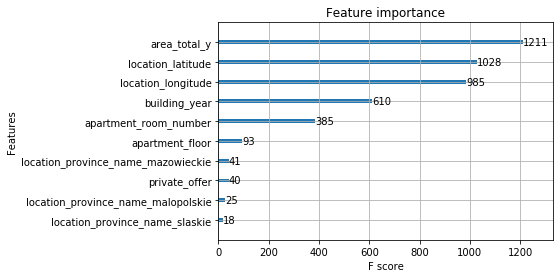

In [164]:
xgb.plot_importance(xg_reg,max_num_features = 10)

In [166]:
# dane pod modele

In [148]:
#modele regresyjne

In [33]:
from statsmodels.formula.api import ols

In [167]:
#regresja wielomianowa
mul_lin_regress = ols("price_y ~ area_total_y + apartment_room_number + location_latitude + location_longitude + building_year + apartment_floor", data).fit()
print(mul_lin_regress.summary().tables[1])

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.637e+05    1.3e+04     12.587      0.000    1.38e+05    1.89e+05
area_total_y              0.3404      0.788      0.432      0.666      -1.204       1.885
apartment_room_number   1.43e+05   1621.362     88.168      0.000     1.4e+05    1.46e+05
location_latitude      -664.9409     74.361     -8.942      0.000    -810.690    -519.192
location_longitude    -1213.8558     55.452    -21.890      0.000   -1322.542   -1105.170
building_year            -5.9816      5.898     -1.014      0.310     -17.542       5.578
apartment_floor        2501.0972   1764.532      1.417      0.156    -957.406    5959.601


In [80]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

In [168]:
model = LinearRegression()
rfe = RFECV(model)
rfe = rfe.fit(x, y)

print(rfe.support_)
print(rfe.ranking_)

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[False  True  True  True False  True  True]
[3 1 1 1 2 1 1]


In [174]:
mul_lin_regress2 = ols("price_y ~  apartment_room_number + location_latitude * location_longitude + apartment_floor+ area_total_y*building_year", data).fit()
print(mul_lin_regress2.summary().tables[1])

                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.484e+05   2.61e+04      5.680      0.000    9.72e+04       2e+05
apartment_room_number                 1.423e+05   1619.030     87.923      0.000    1.39e+05    1.46e+05
location_latitude                    -2127.6929    120.796    -17.614      0.000   -2364.455   -1890.931
location_longitude                   -1767.8661     65.915    -26.820      0.000   -1897.061   -1638.671
location_latitude:location_longitude     5.6355      0.368     15.306      0.000       4.914       6.357
apartment_floor                       5291.0252   1771.298      2.987      0.003    1819.260    8762.790
area_total_y                          1468.1842    333.170      4.407      0.000     815.166    2121.202
building_year                           43.1154     12.

In [175]:
# testowanie modelu

In [153]:
#na podstawie powyższego zestawienia oraz wiedzy, że dla modelu istotne są tylko te dla których P>|t| jest < 0.05

In [177]:
import matplotlib.pyplot as plt
from sklearn.linear_model import  LogisticRegression,LinearRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import sklearn

In [165]:
x=data[['area_total_y','apartment_room_number','location_latitude','location_longitude','building_year','apartment_floor','private_offer']]
y=data['price_y'].values

In [1]:
#drzewo decyzyjne

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

In [179]:
regressor = DecisionTreeRegressor(max_depth=4)

cv_results = cross_validate(regressor, x, y, cv=10)  # this will result in R**2

scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error)

cv_results = cross_validate(regressor, x, y, 
                            scoring=scorer, cv=10)  # this will result in mean squared error
cv_results

{'fit_time': array([0.09636617, 0.17404103, 0.17855477, 0.16988802, 0.17067981,
        0.16852331, 0.16788054, 0.17053604, 0.17227411, 0.17090344]),
 'score_time': array([0.00723696, 0.00660372, 0.00679874, 0.00669336, 0.00657248,
        0.00670481, 0.006598  , 0.00665188, 0.00688243, 0.00673437]),
 'test_score': array([7.23971473e+10, 6.35975989e+10, 8.61970351e+10, 8.04842103e+10,
        5.11489439e+10, 8.61248565e+10, 7.11396557e+10, 7.49268499e+10,
        1.24957044e+11, 1.20239869e+11])}

In [9]:
knn_geo=df3[['location_latitude','location_longitude','location_province_name','location_district_name','location_city_name','location_precinct_name','location_street_name']]

In [10]:
#stworzenie nowej ramki danych która będzie sie składac tylko z rekordów posiadających kordynaty geo i dzielnice

In [10]:
knn_set=knn_geo[(knn_geo['location_latitude'].notnull()) & (knn_geo['location_longitude'].notnull()) & (knn_geo['location_precinct_name'].notnull())]

In [17]:
knn_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64928 entries, 49 to 423642
Data columns (total 7 columns):
location_latitude         64928 non-null float64
location_longitude        64928 non-null float64
location_province_name    62148 non-null object
location_district_name    52930 non-null object
location_city_name        64578 non-null object
location_precinct_name    64928 non-null object
location_street_name      64756 non-null object
dtypes: float64(2), object(5)
memory usage: 4.0+ MB


In [21]:
knn_set.location_precinct_name.nunique()

3103

In [11]:
#metoda kmeans do sklastrowania danych

In [14]:
from sklearn.cluster import KMeans

In [155]:
k_vec = []
int_vec = []

for k in range(2,1000):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    #-- interia - suma kwadratów odlgłości do obserwacji do klastrów
    interia = kmeans.inertia_
    k_vec.append(k)
    int_vec.append(interia)

plt.figure(figsize=(12,10))
plt.title('Wykres sum wariancji klastów')
plt.plot(k_vec,int_vec,'bo-')
plt.xlabel('liczba klastrów')
plt.ylabel('Suma wariancji klastrów')
plt.show()

NameError: name 'KMeans' is not defined

In [41]:
#poprzez kory geo

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.

print(location.address)

In [15]:
import sklearn

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split

In [35]:
onehotencoder = OneHotEncoder(categories='auto')

In [39]:
y = onehotencoder.fit_transform(Y.reshape(-1,1))

In [22]:
#próba zrobienia tego one hot encoder za dużo kombinacji

In [30]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [14]:
# Y=knn_set[['location_precinct_name']]
# encoder = sklearn.preprocessing.OneHotEncoder()
# y = encoder.fit_transform(Y)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.20, random_state=101)

n = 100
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(train_X, train_y)

preds=knn.predict(val_X)
acc=knn.score(val_y, preds)

KeyboardInterrupt: 

In [24]:
#sprawdzenie ile jest rekordów które posiadają kordy geo a nie posiadają dzielnicy

In [27]:
knn_predict=knn_geo[(knn_geo['location_latitude'].notnull()) & (knn_geo['location_longitude'].notnull()) & (knn_geo['location_precinct_name'].isnull())]

In [28]:
knn_predict.count()

location_latitude         60807
location_longitude        60807
location_province_name    50908
location_district_name    33816
location_city_name        59783
location_precinct_name        0
location_street_name      50275
dtype: int64

In [30]:
df3.source_add_date = df3.source_add_date.replace('o ', '')

In [16]:
df['rok']=df['source_add_date'].date.year

AttributeError: 'Series' object has no attribute 'date'

In [11]:
df.groupby(df.main_type_name)['id'].count()

main_type_name
biuro                         311
dom                        106573
działka                     46987
hala/magazyn                  160
komercyjny                  12832
lokal handlowo-usługowy      7104
mieszkanie                 154055
obiekt                       1081
Name: id, dtype: int64

In [ ]:
df.groupby(df.main_type_name)['id'].count()

In [16]:
#modelowanie